# Import

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway, ttest_ind

pd.options.display.max_rows = 50
url = 'https://raw.githubusercontent.com/WHPAN0108/BHT-DataScience-S24/main/data_clean/data/patient_info.csv'
patient_information = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/WHPAN0108/BHT-DataScience-S24/main/data_clean/data/date.csv'
hosptial_visit_information = pd.read_csv(url)


# Task: Data Clean & EDA

## 1. Replace missing BMI values with the median BMI for the corresponding gender.

In [67]:
# Display Null Values
patient_information.isnull().sum()


Participant_ID     0
Sex                0
Age                0
Smoking_status     3
BMI               19
Disease            0
dtype: int64

In [68]:
# Display Null Values
hosptial_visit_information.isnull().sum()

Participant_ID     0
VisitDate         84
dtype: int64

In [69]:

median_bmi_male = patient_information.loc[patient_information['Sex'] == 'Male', 'BMI'].median()
median_bmi_female = patient_information.loc[patient_information['Sex'] == 'Female', 'BMI'].median()

patient_information.loc[(patient_information['Sex'] == 'Male') & (patient_information['BMI'].isnull()), 'BMI'] = median_bmi_male
patient_information.loc[(patient_information['Sex'] == 'Female') & (patient_information['BMI'].isnull()), 'BMI'] = median_bmi_female

# Missing BMI values were set to median BMI 
patient_information['BMI'].isnull().sum()

0

## 2. Perform sanity checks

### 2a. Perform sanity checks on all columns and remove invalid samples for patient_information

In [70]:

def sanity_check(row):
    if not (40 <= row['Age'] <= 125):
        # volunteers must be at least 40 years old and older than 125 is not really realistic
        return False
    if not (15 <= row['BMI'] <= 60):
        # Body Mass Index, should be between 15-60
        return False
    if row['Sex'] not in ['Male', 'Female']:
        # string Male or Female
        return False
    if row['Smoking_status'] not in ['Never', 'Previous', 'Current', 'Prefer not to answer']:
        # string Never, Previous, current, Prefer not to answer
        return False
    if row['Disease'] not in [1, 2]:
        # factor 1 means disease, 2 means healthy
        return False
    if  len(str(row['Participant_ID'])) != 7 or not isinstance(row['Participant_ID'], int):
        # Ensure Participant_ID is numeric and has 7 digits
        return False
    return True

patient_information = patient_information[patient_information.apply(sanity_check, axis=1)]
# Ensure Participant_ID is numeric and has 7 digits
#patient_information = patient_information[patient_information['Participant_ID'].apply(lambda x: isinstance(x, int) and len(str(x)) == 7)]

patient_information.count()



Participant_ID    2210
Sex               2210
Age               2210
Smoking_status    2210
BMI               2210
Disease           2210
dtype: int64

### 2b. Perform sanity checks on all columns and remove invalid samples for hosptial_visit_information

In [71]:

hosptial_visit_information['VisitDate'] = pd.to_datetime(hosptial_visit_information['VisitDate'], errors='coerce')
hosptial_visit_information = hosptial_visit_information.dropna(subset=['VisitDate'])
hosptial_visit_information = hosptial_visit_information[(hosptial_visit_information['VisitDate'].dt.year >= 1950) & (hosptial_visit_information['VisitDate'].dt.year <= 2023)]
hosptial_visit_information = hosptial_visit_information[hosptial_visit_information['Participant_ID'].apply(lambda id: isinstance(id, int) and len(str(id)) == 7)]

hosptial_visit_information.count()


Participant_ID    1121
VisitDate         1121
dtype: int64

## 3. Calculate the number of visits each patient made since 1/1/2020

In [81]:

hosptial_visit_information['Visit_since_2020'] = hosptial_visit_information['VisitDate'] >= pd.Timestamp('2020-01-01')
visits_count = hosptial_visit_information[hosptial_visit_information['Visit_since_2020']].groupby('Participant_ID').size().reset_index(name='Number_of_visits')

# Ensure all patients are included
all_patients = patient_information[['Participant_ID']]
visits_count = all_patients.merge(visits_count, on='Participant_ID', how='left').fillna({'Number_of_visits': 0})
visits_count


,Participant_ID,Number_of_visits
0,1003300,1.0
1,1004025,0.0
2,1005551,0.0
3,1005594,0.0
4,1005624,0.0
...,...,...
2205,6009769,0.0
2206,6011693,0.0
2207,6015403,0.0
2208,6019982,0.0


## 4. Create a summary table/chart showing the number of visits for each month

In [82]:

hosptial_visit_information['Month'] = hosptial_visit_information['VisitDate'].dt.to_period('M')
monthly_visits = hosptial_visit_information.groupby('Month').size().reset_index(name='Number_of_visits')
monthly_visits


,Month,Number_of_visits
0,1997-06,1
1,1997-07,1
2,1998-02,1
3,1998-10,1
4,1999-06,2
...,...,...
241,2022-08,5
242,2022-09,9
243,2022-10,9
244,2022-11,8


## 5. Add a new column "age group"

In [83]:

bins = [40, 50, 60, 70, 120]
labels = ['40-49', '50-59', '60-69', '70+']
patient_information['Age_group'] = pd.cut(patient_information['Age'], bins=bins, labels=labels, right=False)
patient_information


,Participant_ID,Sex,Age,Smoking_status,BMI,Disease,Age_group
0,1003300,Male,62,Previous,33.7597,2,60-69
1,1004025,Male,60,Previous,28.1173,1,60-69
2,1005551,Male,69,Previous,26.4159,2,60-69
3,1005594,Male,64,Previous,24.7550,1,60-69
4,1005624,Male,64,Previous,35.0773,2,60-69
...,...,...,...,...,...,...,...
2211,6009769,Male,48,Previous,39.3345,2,40-49
2212,6011693,Male,62,Previous,30.8813,2,60-69
2213,6015403,Female,60,Previous,34.7276,1,60-69
2214,6019982,Male,54,Never,25.3287,2,50-59


## 6. Merge the two files to create the final dataset

In [84]:
final_data = patient_information.merge(visits_count, on='Participant_ID', how='left').fillna({'Number_of_visits': 0})

# Select and arrange columns as required
final_data = final_data[['Participant_ID', 'Sex', 'Age', 'BMI', 'Smoking_status', 'Number_of_visits', 'Disease', 'Age_group']]
final_data

,Participant_ID,Sex,Age,BMI,Smoking_status,Number_of_visits,Disease,Age_group
0,1003300,Male,62,33.7597,Previous,1.0,2,60-69
1,1004025,Male,60,28.1173,Previous,0.0,1,60-69
2,1005551,Male,69,26.4159,Previous,0.0,2,60-69
3,1005594,Male,64,24.7550,Previous,0.0,1,60-69
4,1005624,Male,64,35.0773,Previous,0.0,2,60-69
...,...,...,...,...,...,...,...,...
2205,6009769,Male,48,39.3345,Previous,0.0,2,40-49
2206,6011693,Male,62,30.8813,Previous,0.0,2,60-69
2207,6015403,Female,60,34.7276,Previous,0.0,1,60-69
2208,6019982,Male,54,25.3287,Never,0.0,2,50-59


# Task: Statistics

## 1. Compare the BMI between the healthy and control groups using a box or violin plot.

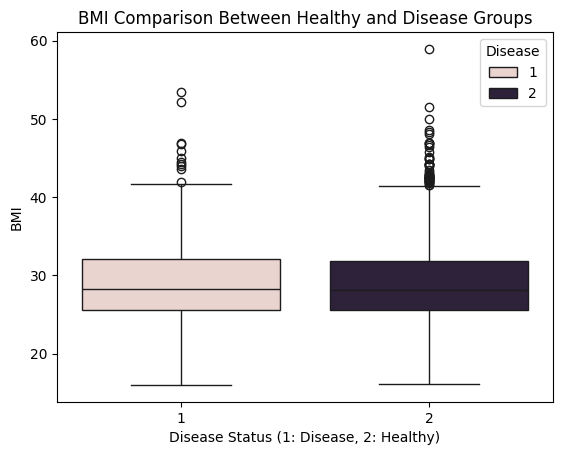

In [76]:
sns.boxplot(x='Disease', y='BMI', data=final_data, hue='Disease')
plt.title('BMI Comparison Between Healthy and Disease Groups')
plt.xlabel('Disease Status (1: Disease, 2: Healthy)')
plt.ylabel('BMI')
plt.show()

We see that the BMI of most participants is in the range of 25-32 regardless of the disease. Among the healthy participants, however, there are some people with a higher BMI.

## 2. Examine if the proportion of smoking status differs between the healthy and control groups.

In [77]:

# Create a contingency_table
contingency_table = pd.crosstab(final_data['Smoking_status'], final_data['Disease'])
print("Difference in smoking status between the healthy and the sick group")
print(contingency_table)

# Perform a chi-squared test
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-squared test results: chi2={chi2}, p-value={p}, dof={dof}")

Difference in smoking status between the healthy and the sick group
Disease                 1    2
Smoking_status                
Current                92  258
Never                 214  635
Prefer not to answer    5    4
Previous              254  748
Chi-squared test results: chi2=4.431338646099254, p-value=0.2184971000961656, dof=3


Since the p-value (0.218) is greater than the commonly used significance level (0.05), we fail to reject the null hypothesis.
This means that there is no statistically significant association between smoking status and disease status.

## 3. Analyze the relationship between smoking status and the number of hospital visits, separately for the disease and healthy groups, and for the overall population.

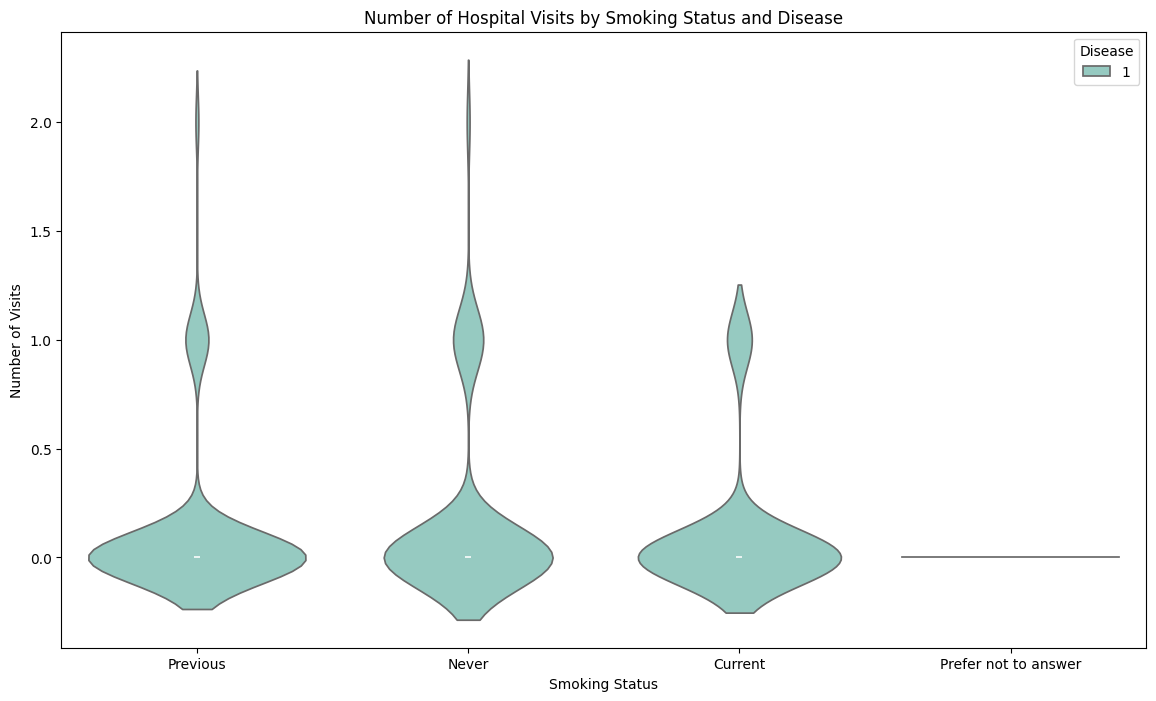

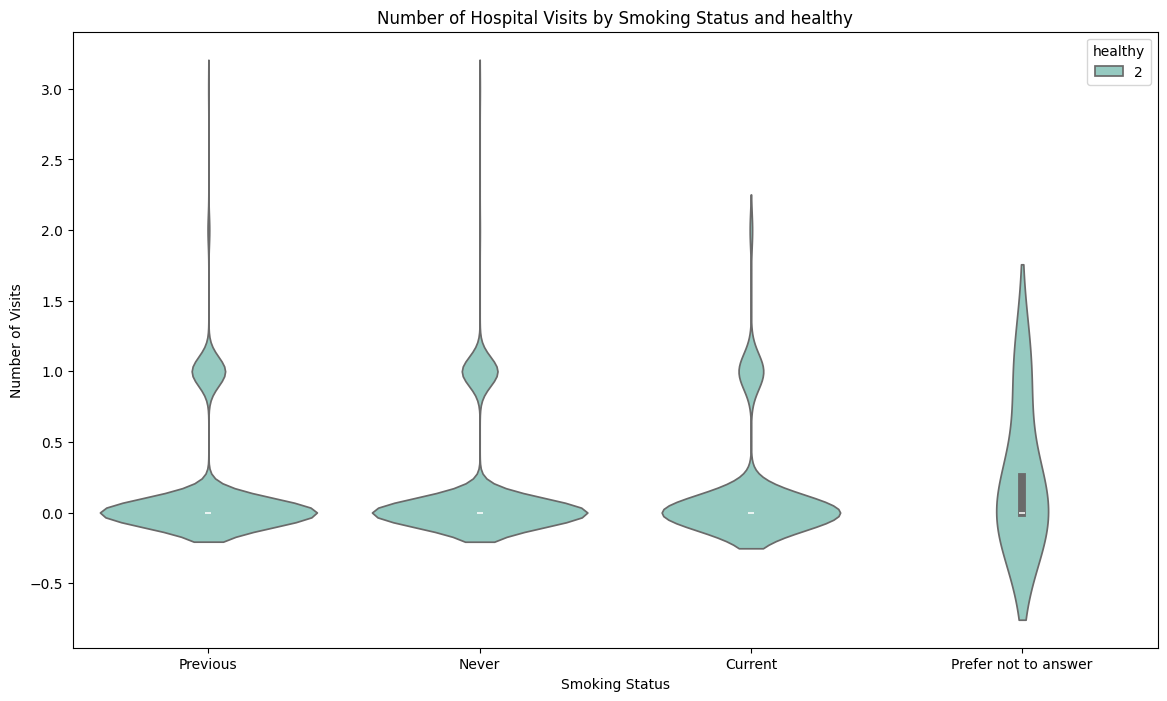

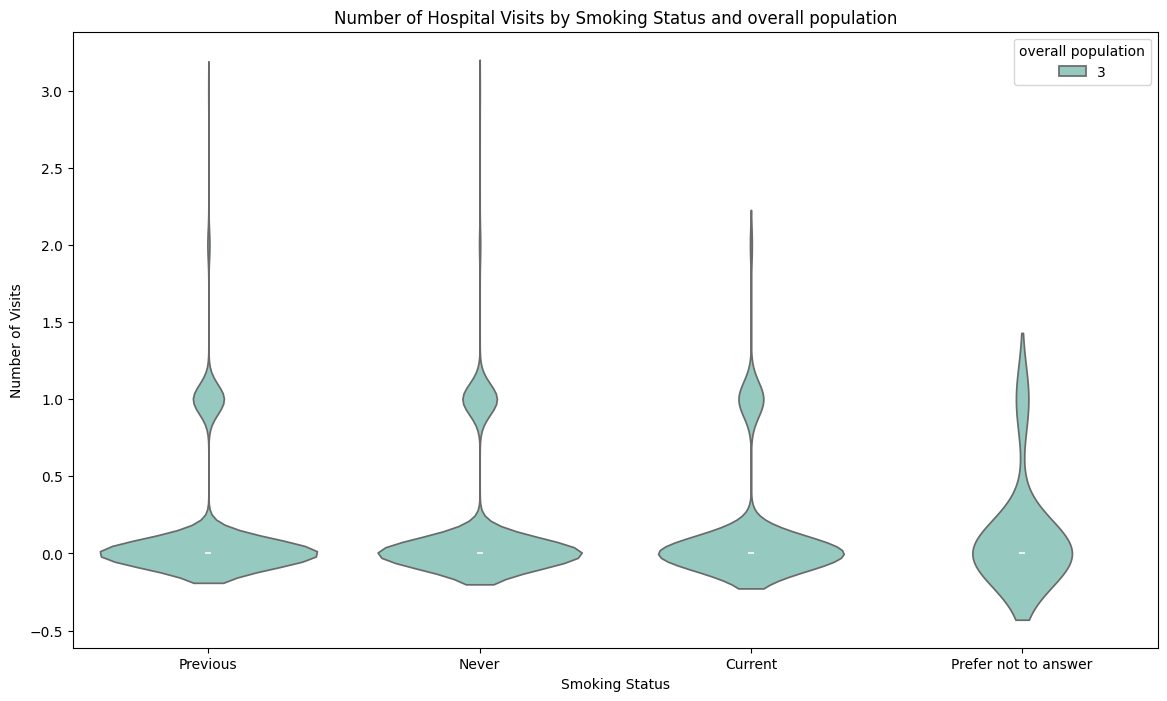

diseases
ANOVA test statistic: 1.4503548034126854
p-value: 0.22719066483550945
healthy
ANOVA test statistic: 0.11352787365826687
p-value: 0.9522100745760795
overall_population
ANOVA test statistic: 0.40214076825197037
p-value: 0.7514779282447345


In [78]:


disease_only = final_data[final_data['Disease'] == 1]

plt.figure(figsize=(14, 8))
sns.violinplot(x='Smoking_status', y='Number_of_visits', hue='Disease', data=disease_only, palette="Set3")
plt.title('Number of Hospital Visits by Smoking Status and Disease')
plt.xlabel('Smoking Status')
plt.ylabel('Number of Visits')
plt.legend(title='Disease')
plt.show()
healthy_only = final_data[final_data['Disease'] == 2]

plt.figure(figsize=(14, 8))
sns.violinplot(x='Smoking_status', y='Number_of_visits', hue='Disease', data=healthy_only, palette="Set3")
plt.title('Number of Hospital Visits by Smoking Status and healthy')
plt.xlabel('Smoking Status')
plt.ylabel('Number of Visits')
plt.legend(title='healthy')
plt.show()

overall_population = final_data.copy()
overall_population['Disease'] = 3

plt.figure(figsize=(14, 8))
sns.violinplot(x='Smoking_status', y='Number_of_visits', hue='Disease', data=overall_population, palette="Set3")
plt.title('Number of Hospital Visits by Smoking Status and overall population')
plt.xlabel('Smoking Status')
plt.ylabel('Number of Visits')
plt.legend(title='overall population')
plt.show()


# Prepare the data for the ANOVA test
grouped_data = [group['Number_of_visits'].values for name, group in disease_only.groupby('Smoking_status')]

# Perform the ANOVA test
anova_result = f_oneway(*grouped_data)

# Print the test results
print(f'diseases')
print(f'ANOVA test statistic: {anova_result.statistic}')
print(f'p-value: {anova_result.pvalue}')

# Prepare the data for the ANOVA test
grouped_data = [group['Number_of_visits'].values for name, group in healthy_only.groupby('Smoking_status')]

# Perform the ANOVA test
anova_result = f_oneway(*grouped_data)

# Print the test results
print(f'healthy')
print(f'ANOVA test statistic: {anova_result.statistic}')
print(f'p-value: {anova_result.pvalue}')

# Prepare the data for the ANOVA test
grouped_data = [group['Number_of_visits'].values for name, group in overall_population.groupby('Smoking_status')]

# Perform the ANOVA test
anova_result = f_oneway(*grouped_data)

# Print the test results
print(f'overall_population')
print(f'ANOVA test statistic: {anova_result.statistic}')
print(f'p-value: {anova_result.pvalue}')



Since the p-value of all groups is greater than the commonly used significance level (0.05), we fail to reject the null hypothesis.
This means that there is no statistically significant association between smoking status and the number of visits. Also the graphs dont show any significance difference between the the groups.

## 4. Determine if the number of visits is higher in the disease group compared to the healthy group.

In [79]:
# Split the data into disease and healthy groups
disease_only = final_data[final_data['Disease'] == 1]['Number_of_visits']
healthy_only = final_data[final_data['Disease'] == 2]['Number_of_visits']

# Perform the right-tail t-test
t_stat, p_value = ttest_ind(disease_only, healthy_only, alternative='greater')

# Print the test results
print(f'T-test statistic: {t_stat}')
print(f'p-value: {p_value}')

T-test statistic: -0.5883346918994362
p-value: 0.7218160816061883


Alse here the p-value is greater than the commonly used significance level (0.05), we fail to reject the null hypothesis.
This means that there is no statistically significant association between the number of visits and the healthy status

## 5. Calculate the disease prevalence (number of sick  / total number population) across different age groups  in our dataset, and test if the prevalence is different across the group

Disease Prevalence by Age Group:
  Age_group  Disease_Prevalence
0     40-49            0.270968
1     50-59            0.217304
2     60-69            0.267236
3       70+            0.228571


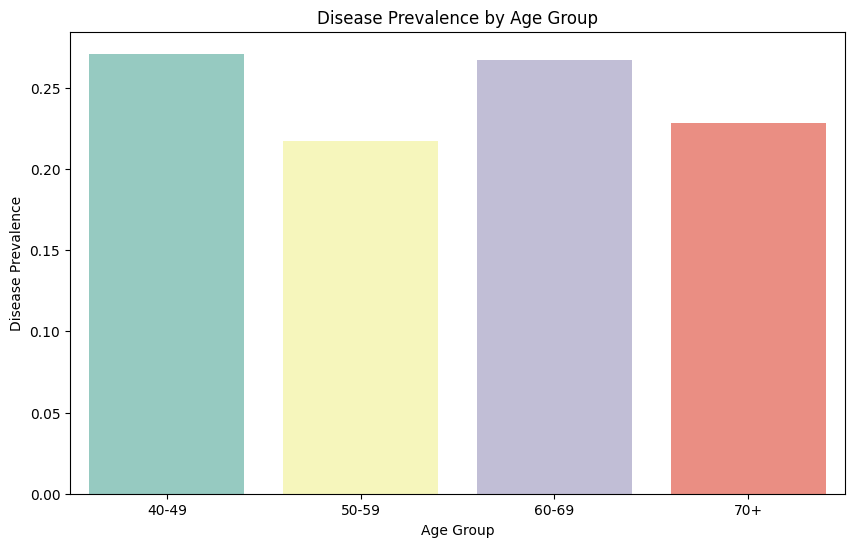

Chi-squared test results for age groups: chi2=5.240600979562111, p-value=0.15500347379532825, dof=3


In [80]:

age_group_prevalence = final_data.groupby('Age_group', observed=False )['Disease'].apply(lambda x: (x == 1).mean()).reset_index()
age_group_prevalence.columns = ['Age_group', 'Disease_Prevalence']
print("Disease Prevalence by Age Group:")
print(age_group_prevalence)

# Plot prevalence
plt.figure(figsize=(10, 6))
sns.barplot(x='Age_group', y='Disease_Prevalence', hue='Age_group', data=age_group_prevalence, palette="Set3")
plt.title('Disease Prevalence by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Disease Prevalence')
plt.show()

# Perform chi-squared test to see if prevalence is different across age groups
contingency_table_age = pd.crosstab(final_data['Age_group'], final_data['Disease'])
chi2_age, p_age, dof_age, ex_age = chi2_contingency(contingency_table_age)
print(f"Chi-squared test results for age groups: chi2={chi2_age}, p-value={p_age}, dof={dof_age}")




Alse here the p-value is greater than the commonly used significance level (0.05), we fail to reject the null hypothesis.
This means that there is no statistically significant association between the age group and the healthy status. Each group has approx. 22-27% of sick people.